# Kaggle Tabular California House Price Prediction Competition

# 1. Import Data

In [32]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# upload dataset
df = pd.read_csv("train.csv")

# 2. Data Exploration

In [34]:
df.dtypes

id               int64
MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

In [35]:
df.describe()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,37137.00000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,18568.00000,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329,2.079751
std,10720.67281,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028,1.158571
min,0.00000,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000,0.149990
25%,9284.00000,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000,1.208000
50%,18568.00000,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000,1.808000
75%,27852.00000,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000,2.660000
max,37136.00000,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000,5.000010


In [36]:
df.isnull().sum()

id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [37]:
df.columns

Index(['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

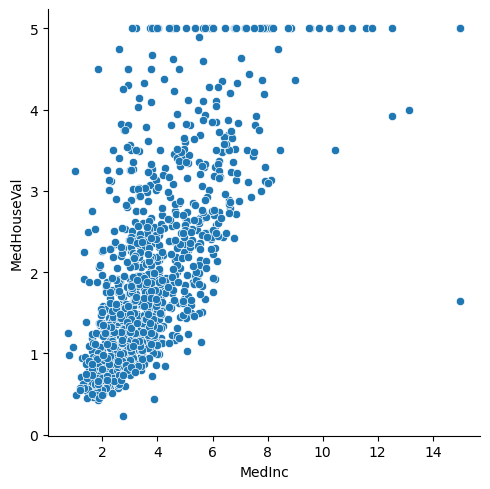

In [38]:
# looking at possible correlations to predict MedHouseVal
sns.relplot(x='MedInc', y='MedHouseVal', data=df.sample(1000, random_state=42))

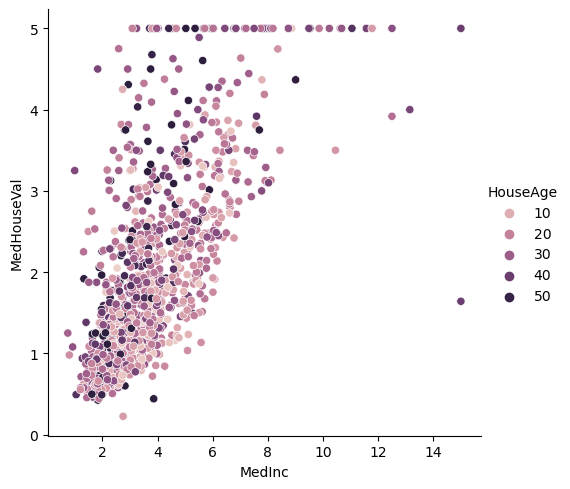

In [39]:
sns.relplot(x='MedInc', y='MedHouseVal', hue="HouseAge", data=df.sample(1000, random_state=42))

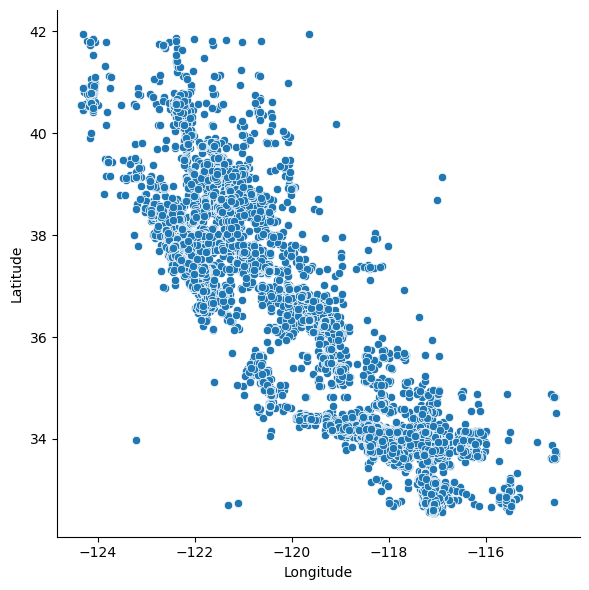

In [40]:
sns.relplot(
    x="Longitude", y="Latitude", data=df, height=6,
)

# 3. Developing ratios that I can implement and test to improve my model's accuracy.

In [41]:
df.columns

Index(['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

In [42]:
df['inc_ratio'] = df['MedInc'] / df['HouseAge']

In [43]:
df['location_ratio'] = df['Latitude'] / df['Longitude']

In [44]:
df["location_bin"] = pd.qcut(df["location_ratio"], q=5, duplicates="drop")

In [45]:
df["medincratio"] = df["MedInc"] / df['location_ratio']

In [46]:
df['lat_lon_interaction'] = df['Latitude'] * df['Longitude']

In [47]:
df["loc_income_interaction"] = df["location_ratio"] * df["MedInc"]

In [48]:
df["rooms_people_hmean"] = 2 / (1/(df["AveRooms"]+1e-6) + 1/(df["AveOccup"]+1e-6))
df["inc_rooms_gmean"]   = np.sqrt(np.clip(df["MedInc"],0,None) * np.clip(df["AveRooms"],0,None))

In [49]:
df["lat_centered"] = df["Latitude"] - df["Latitude"].mean()
df["lon_centered"] = df["Longitude"] - df["Longitude"].mean()
df["distance_from_center"] = np.sqrt(df["lat_centered"]**2 + df["lon_centered"]**2)


In [50]:
df["combined"] = df['AveBedrms'] / df['AveRooms']

In [51]:
df['bedrooms_per_room'] = df['AveBedrms'] / (df['AveRooms'] + 1e-6)
df['rooms_per_person']  = df['AveRooms']  / (df['AveOccup'] + 1e-6)
df['pop_per_household'] = df['Population']/ (df['AveOccup'] + 1e-6)
df['lat_x_lon'] = df['Latitude'] * df['Longitude']

In [52]:
df[["MedInc", 'location_ratio']].head(10)

,MedInc,location_ratio
0,2.3859,-0.288045
1,3.7188,-0.319172
2,4.7750,-0.288169
3,2.4138,-0.278931
4,3.7500,-0.308798
5,6.8075,-0.286028
6,2.3654,-0.303043
7,2.3562,-0.279149
8,2.2672,-0.317302
9,5.6370,-0.286245


# 4. Building my model

In [53]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [54]:
x = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude',  'location_ratio']]
y = df['MedHouseVal']

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
from lightgbm import LGBMRegressor

In [105]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [106]:
# Developing and optimized my model and its hyper parameters.
model = LGBMRegressor(
    n_estimators=1269,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=30,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)
model.fit(x_train, y_train)
predict = model.predict(x_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 27852, number of used features: 9
[LightGBM] [Info] Start training from score 2.076495


In [107]:
# viewing the root mean error of my results
mse = mean_squared_error(y_test, predict,squared=False)
print("The Mean Squared Error is:", mse)

The Mean Squared Error is: 0.5752677936563203


# 5. Continued Feature Engineering

In [108]:
from sklearn.feature_selection import mutual_info_regression

In [109]:
# seeing which features provided the highest value to predicting my model to continue feature engineering.
mi_scores = mutual_info_regression(x, y)
mi_scores
pd.DataFrame({"Feature": x.columns, "Value": mi_scores}).sort_values("Value", ascending=False)

,Feature,Value
0,MedInc,0.459213
7,Longitude,0.413445
6,Latitude,0.343132
8,location_ratio,0.311385
2,AveRooms,0.146973
5,AveOccup,0.090126
1,HouseAge,0.075770
4,Population,0.070644
3,AveBedrms,0.038312


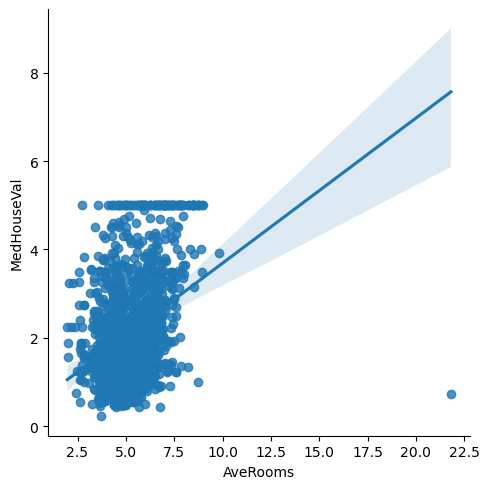

In [110]:
# Continuing looking at plots to find possible correlations
sns.lmplot(x="AveRooms", y="MedHouseVal", data=df.sample(1500, random_state=42))

# 6. Saving my model to deploy into another

In [111]:
# Saving my model to deploy in another data set
import joblib

joblib.dump(model, "lgbmregressor.pkl")

model = joblib.load("lgbmregressor.pkl")

In [112]:
df2 = pd.read_csv("test.csv")

In [113]:
# using same feature engineer from first data set into second data set
df2['location_ratio'] = df2['Latitude'] / df2['Longitude']

In [114]:
df2.columns

Index(['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'location_ratio'],
      dtype='object')

In [115]:
x2 = df2[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'location_ratio']]

In [116]:
# predicting outcomes of second dataset and storing the results
test_predict = model.predict(x2)

In [117]:
# Building a data frame to submit my models predictions into Kaggle's competitions submission.
submission12 = pd.DataFrame({"id": df2['id'], "MedHouseVal": test_predict})
submission12.to_csv("submission12.csv", index=False)

In [118]:
# Viewing if Data Frame is accurate.
submission12

,id,MedHouseVal
0,37137,0.641705
1,37138,0.974345
2,37139,4.109190
3,37140,3.261623
4,37141,2.536524
...,...,...
24754,61891,2.332407
24755,61892,1.985352
24756,61893,1.157651
24757,61894,3.638426


# Kaggle Competition Link: https://www.kaggle.com/competitions/regression-tabular-california-housing/overview